#### Plots for MS committee meeting 


- Timeseries plot of DITN & LDEO temp, salinity, and velocity at various depths 
- Sliding window lag correlation analysis between DITN and LDEO (based on time series) 
- Timeseries plots of DITN history 
- T/S diagrams of DITN history 
- Timeseries plot of LDEO and mooring D, and sliding window lag correlation if makes sense 
- Timeseries plots of DITD and TNBD, sliding window lag correlation analysis 
- Timeseries and T/S diagrams for historical DITD
- T/S diagram for 2018 (TNBD, DITD)
- T/S diagram for DITD and D overlapping years (2017, 2019/20, 2021/22)
- T/S diagram for DITN, LDEO 2017, and D  


In [1]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import gsw 
import glob
import pandas as pd 


In [2]:
def summarize_all(dt):
    """Return a DataFrame summarizing the entire DataTree."""
    import pandas as pd
    import numpy as np

    rows = []

    for mooring, mooring_node in dt.children.items():
        for year, year_node in mooring_node.children.items():
            for instrument, instr_node in year_node.children.items():
                for position, pos_node in instr_node.children.items():

                    ds = pos_node.ds

                    if "time" in ds.coords:
                        t = ds["time"].to_numpy()
                        t_start = t[0]
                        t_end = t[-1]
                        dt_med = np.median(np.diff(t)) if len(t) > 1 else np.nan
                    else:
                        t_start = t_end = dt_med = np.nan

                    depth = ds.coords["z"].item() if "z" in ds.coords else np.nan

                    rows.append({
                        "mooring": mooring,
                        "year": year,
                        "instrument": instrument,
                        "position": position,
                        "depth": depth,
                        "variables": list(ds.data_vars),
                        "time_start": t_start,
                        "time_end": t_end,
                        "sampling_period": dt_med,
                        "n_points": ds.sizes.get("time", np.nan),
                    })

    df = pd.DataFrame(rows)
    df = df.sort_values(["mooring", "year", "instrument", "position"])
    return df.reset_index(drop=True)


In [3]:
def plot_timeseries(years,var,mooring,instrument,position,color,label):
    """
    inputs:
    years: years to loop over (array containing years in string format)
    var: variable of interest (string)
    mooring: mooring of interest (string)
    instrument: instrument of interest (string)
    position: position of interest (string)
    color: color to use for line plotting (string)
    """
    for i in range(len(years)):
        var = var
        ds = dt[mooring][years[i]][instrument][position]
        if var in ds.data_vars:
            ds[var].plot(color=color,label=label)

In [4]:
# load in individual datasets for now for each mooring - figure out datatree structure later 
dt = xr.open_datatree('TNB_mooring_datatree.nc')

In [5]:
df = summarize_all(dt)

In [6]:
df

,mooring,year,instrument,position,depth,variables,time_start,time_end,sampling_period,n_points
0,D,2014,ctd,bot,-1069,"[T_0, S_0, S_1, S_2, T_2]",2014-01-22 13:30:00.000000000,2016-02-01 17:00:00.000000000,0 days 00:30:00,35528.0
1,D,2014,ctd,top,-509,"[S_0, T_0, S_2, S_1, T_2]",2014-01-22 00:00:00.000000000,2016-01-31 10:00:00.000000000,0 days 00:30:00,35493.0
2,D,2014,temp,mid1,-739,"[T_0, T_2]",2014-01-22 00:00:00.000000000,2016-01-31 11:00:00.000000000,0 days 00:10:00,106483.0
3,D,2014,temp,mid2,-966,"[T_0, T_2]",2014-01-22 00:00:00.000000000,2016-01-31 11:00:00.000000000,0 days 00:10:00,106483.0
4,D,2014,vel,bot,-1112,"[U_0, V_0, Mod_0, Dir_0, TiltX, TiltY, Heading...",2014-01-21 01:30:00.000000000,2015-05-14 16:00:00.000000000,0 days 00:30:00,22974.0
...,...,...,...,...,...,...,...,...,...,...
157,P3,2018,ctd,top,1262,"[pressure, temp, sal, cond]",2018-02-19 21:45:01.000004608,2019-01-17 10:55:00.999995648,0 days 00:05:00.000002304,95487.0
158,TNBD,2018,ctd,bot,1093,"[temp, pressure, absolute_salinity, conservati...",2018-03-13 00:01:43.000000000,2019-01-04 23:58:43.000000000,0 days 00:03:00,143040.0
159,TNBD,2018,ctd,top,999,"[temp, pressure, absolute_salinity, conservati...",2018-03-13 00:00:43.000000000,2019-01-04 23:59:43.000000000,0 days 00:01:00,429120.0
160,TNBD,2018,vel,bot,1093,"[east, north, up, pressure_dbar, pressure, spe...",2018-03-12 00:00:00.000000000,2019-01-03 23:59:54.000000000,0 days 00:15:00,28610.0


### Load Data 

Data to load: 

- TNBD top and bottom sensors (ctd + velocity)
- DITD (full dataset)
- DITN (full dataset)
- LDEO (full dataset)
- D (full dataset)

#### Load LDEO data 

In [7]:
LDEO_ctd = xr.open_dataset('/Users/mblan/Documents/TNB_Research/data/LDEO_TNB_mooring_data_QC/LDEO_TNB_temperature_salinity.nc')
LDEO_vel_top = xr.open_dataset('/Users/mblan/Documents/TNB_Research/data/LDEO_TNB_mooring_data_QC/LDEO_TNB_230m_current_velocity.nc')
LDEO_vel_mid = xr.open_dataset('/Users/mblan/Documents/TNB_Research/data/LDEO_TNB_mooring_data_QC/LDEO_TNB_300m_current_velocity.nc')
LDEO_vel_bot = xr.open_dataset('/Users/mblan/Documents/TNB_Research/data/LDEO_TNB_mooring_data_QC/LDEO_TNB_370m_current_velocity.nc')
LDEO_awac = xr.open_dataset('/Users/mblan/Documents/TNB_Research/data/LDEO_TNB_mooring_data_QC/LDEO_TNB_40m_surface_current_profiles.nc')

In [8]:
LDEO_datasets = [
    LDEO_ctd,
    LDEO_vel_top,
    LDEO_vel_mid,
    LDEO_vel_bot,
    LDEO_awac
]

#### load DITN data 

In [77]:
df.query("mooring == 'P3'")

,mooring,year,instrument,position,depth,variables,time_start,time_end,sampling_period,n_points
155,P3,2018,ctd,bot,1667,"[pressure, temp, sal, cond]",2018-02-19 21:45:01.000004608,2019-01-17 10:55:00.999995648,0 days 00:05:00.000002304,95487.0
156,P3,2018,ctd,mid,1414,"[pressure, temp, sal, cond]",2018-02-19 21:45:01.000004608,2019-01-17 10:55:00.999995648,0 days 00:05:00.000002304,95487.0
157,P3,2018,ctd,top,1262,"[pressure, temp, sal, cond]",2018-02-19 21:45:01.000004608,2019-01-17 10:55:00.999995648,0 days 00:05:00.000002304,95487.0


In [9]:
# load in all datasets for DITD mooring 
paths = glob.glob("//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN/*.nc")

In [10]:
paths

['//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121625.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121626.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121627.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121628.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121629.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121630.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121631.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121632.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121633.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121634.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121635.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121636.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121637.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121638.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITN\\121639.nc',
 '//thepenguin/penguin2/Data/TNB/mooring

In [11]:
# create a list to hold datasets 
ds_list = []
for path in paths:
    ds = xr.open_dataset(path)
    ds_list.append(ds)

In [12]:
for i in range(len(ds_list)):
    print(ds_list[i].attrs['description'] + ', depth= ' + ds_list[i].z.values.astype(str))
# print(ds_list[1].attrs['description'] + ', depth= ' + ds_list[1].z.values.astype(str))

['Mooring DITN 1412 rcm9, depth= 75' 'Mooring DITN 1412 rcm9, depth= 276'
 'Mooring DITN 1412 rcm9, depth= 674']
['Mooring DITN 1412 SBE37SM, depth= 77'
 'Mooring DITN 1412 SBE37SM, depth= 278'
 'Mooring DITN 1412 SBE37SM, depth= 667']
['Mooring DITN 1412 SBE56, depth= 108'
 'Mooring DITN 1412 SBE56, depth= 148'
 'Mooring DITN 1412 SBE56, depth= 188'
 'Mooring DITN 1412 SBE56, depth= 228']
['Mooring DITN 1512 SBE37SM, depth= 73'
 'Mooring DITN 1512 SBE37SM, depth= 275'
 'Mooring DITN 1512 SBE37SM, depth= 666']
['Mooring DITN 1512 rcm9, depth= 71' 'Mooring DITN 1512 rcm9, depth= 273'
 'Mooring DITN 1512 rcm9, depth= 667']
['Mooring DITN 1512 SBE56, depth= 113'
 'Mooring DITN 1512 SBE56, depth= 153'
 'Mooring DITN 1512 SBE56, depth= 193'
 'Mooring DITN 1512 SBE56, depth= 233']
['Mooring DITN 1702 AQD, depth= 76' 'Mooring DITN 1702 AQD, depth= 271'
 'Mooring DITN 1702 AQD, depth= 694']
['Mooring DITN 1702 rcm9, depth= 75' 'Mooring DITN 1702 rcm9, depth= 270'
 'Mooring DITN 1702 rcm9, dept

In [13]:
# sepearte mooring data by top, mid, bottom sensors 
DITN_2014_speed_top = ds_list[0].sel(z=75).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})
DITN_2014_speed_mid = ds_list[0].sel(z=276).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})
DITN_2014_speed_bot = ds_list[0].sel(z=674).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})

DITN_2014_ctd_top = ds_list[1].sel(z=77).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})
DITN_2014_ctd_mid = ds_list[1].sel(z=278).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})
DITN_2014_ctd_bot = ds_list[1].sel(z=667).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})

DITN_2014_temp_top = ds_list[2].sel(z=108).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})
DITN_2014_temp_mid1 = ds_list[2].sel(z=148).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})
DITN_2014_temp_mid2 = ds_list[2].sel(z=188).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})
DITN_2014_temp_bot = ds_list[2].sel(z=228).rename({'DateTime':'time'}).assign_coords({'lat':-75.3602,'lon':164.7495})

DITN_2015_ctd_top = ds_list[3].sel(z=73).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})
DITN_2015_ctd_mid = ds_list[3].sel(z=275).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})
DITN_2015_ctd_bot = ds_list[3].sel(z=666).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})

DITN_2015_speed_top = ds_list[4].sel(z=71).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})
DITN_2015_speed_mid = ds_list[4].sel(z=273).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})
DITN_2015_speed_bot = ds_list[4].sel(z=667).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})

DITN_2015_temp_top = ds_list[5].sel(z=113).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})
DITN_2015_temp_mid1 = ds_list[5].sel(z=153).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})
DITN_2015_temp_mid2 = ds_list[5].sel(z=193).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})
DITN_2015_temp_bot = ds_list[5].sel(z=233).rename({'DateTime':'time'}).assign_coords({'lat':-75.3601,'lon':164.7486})

DITN_2017_vel_top = ds_list[6].sel(z=76).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})
DITN_2017_vel_mid = ds_list[6].sel(z=271).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})
DITN_2017_vel_bot = ds_list[6].sel(z=694).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})

DITN_2017_speed_top = ds_list[7].sel(z=75).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})
DITN_2017_speed_mid = ds_list[7].sel(z=270).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})
DITN_2017_speed_bot = ds_list[7].sel(z=667).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})

DITN_2017_ctd_top = ds_list[8].sel(z=75).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})
DITN_2017_ctd_mid = ds_list[8].sel(z=275).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})
DITN_2017_ctd_bot = ds_list[8].sel(z=675).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})

DITN_2017_temp_top = ds_list[9].sel(z=197).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})
DITN_2017_temp_mid = ds_list[9].sel(z=330).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})
DITN_2017_temp_bot = ds_list[9].sel(z=360).rename({'DateTime':'time'}).assign_coords({'lat':-75.3608,'lon':164.7465})

DITN_2018_ctd_top = ds_list[10].sel(z=73).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})
DITN_2018_ctd_mid = ds_list[10].sel(z=274).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})
DITN_2018_ctd_bot = ds_list[10].sel(z=670).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})

DITN_2018_temp_top = ds_list[11].sel(z=114).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})
DITN_2018_temp_mid1 = ds_list[11].sel(z=154).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})
DITN_2018_temp_mid2 = ds_list[11].sel(z=194).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})
DITN_2018_temp_bot = ds_list[11].sel(z=224).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})

DITN_2018_vel_top = ds_list[13].sel(z=71).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})
DITN_2018_vel_mid = ds_list[13].sel(z=263).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})
DITN_2018_vel_bot = ds_list[13].sel(z=666).rename({'DateTime':'time'}).assign_coords({'lat':-75.361,'lon':164.7430})

DITN_2019_vel_top = ds_list[12].sel(z=67).rename({'DateTime':'time'}).assign_coords({'lat':-75.3486,'lon':164.8159})
DITN_2019_vel_mid = ds_list[12].sel(z=255).rename({'DateTime':'time'}).assign_coords({'lat':-75.3486,'lon':164.8159})
DITN_2019_vel_bot = ds_list[12].sel(z=649).rename({'DateTime':'time'}).assign_coords({'lat':-75.3486,'lon':164.8159})

DITN_2019_ctd_top = ds_list[14].sel(z=71).rename({'DateTime':'time'}).assign_coords({'lat':-75.3486,'lon':164.8159})
DITN_2019_ctd_mid = ds_list[14].sel(z=271).rename({'DateTime':'time'}).assign_coords({'lat':-75.3486,'lon':164.8159})

DITN_2019_temp_top = ds_list[15].sel(z=112).rename({'DateTime':'time'}).assign_coords({'lat':-75.3486,'lon':164.8159})
DITN_2019_temp_mid1 = ds_list[15].sel(z=152).rename({'DateTime':'time'}).assign_coords({'lat':-75.3486,'lon':164.8159})
DITN_2019_temp_mid2 = ds_list[15].sel(z=192).rename({'DateTime':'time'}).assign_coords({'lat':-75.3486,'lon':164.8159})
DITN_2019_temp_bot = ds_list[15].sel(z=232).rename({'DateTime':'time'}).assign_coords({'lat':-75.3486,'lon':164.8159})

DITN_2020_vel_top = ds_list[16].sel(z=54).rename({'DateTime':'time'}).assign_coords({'lat':-75.3493,'lon':164.8170})
DITN_2020_vel_mid = ds_list[16].sel(z=252).rename({'DateTime':'time'}).assign_coords({'lat':-75.3493,'lon':164.8170})
DITN_2020_vel_bot = ds_list[16].sel(z=671).rename({'DateTime':'time'}).assign_coords({'lat':-75.3493,'lon':164.8170})

DITN_2020_ctd_mid = ds_list[17].sel(z=269).rename({'DateTime':'time'}).assign_coords({'lat':-75.3493,'lon':164.8170})
DITN_2020_ctd_bot = ds_list[17].sel(z=667).rename({'DateTime':'time'}).assign_coords({'lat':-75.3493,'lon':164.8170})

DITN_2020_temp_top = ds_list[18].sel(z=95).rename({'DateTime':'time'}).assign_coords({'lat':-75.3493,'lon':164.8170})
DITN_2020_temp_mid1 = ds_list[18].sel(z=135).rename({'DateTime':'time'}).assign_coords({'lat':-75.3493,'lon':164.8170})
DITN_2020_temp_mid2 = ds_list[18].sel(z=175).rename({'DateTime':'time'}).assign_coords({'lat':-75.3493,'lon':164.8170})
DITN_2020_temp_bot = ds_list[18].sel(z=215).rename({'DateTime':'time'}).assign_coords({'lat':-75.3493,'lon':164.8170})



In [14]:
DITN_datasets = [
    DITN_2014_speed_top,
    DITN_2014_speed_mid,
    DITN_2014_speed_bot,
    DITN_2014_ctd_top,
    DITN_2014_ctd_mid,
    DITN_2014_ctd_bot,
    DITN_2014_temp_top,
    DITN_2014_temp_mid1,
    DITN_2014_temp_mid2,
    DITN_2014_temp_bot,
    DITN_2015_ctd_top,
    DITN_2015_ctd_mid,
    DITN_2015_ctd_bot,
    DITN_2015_speed_top,
    DITN_2015_speed_mid,
    DITN_2015_speed_bot,
    DITN_2015_temp_top,
    DITN_2015_temp_mid1,
    DITN_2015_temp_mid2,
    DITN_2015_temp_bot,
    DITN_2017_vel_top,
    DITN_2017_vel_mid,
    DITN_2017_vel_bot,
    DITN_2017_speed_top,
    DITN_2017_speed_mid,
    DITN_2017_speed_bot,
    DITN_2017_ctd_top,
    DITN_2017_ctd_mid,
    DITN_2017_ctd_bot,
    DITN_2017_temp_top,
    DITN_2017_temp_mid,
    DITN_2017_temp_bot,
    DITN_2018_ctd_top,
    DITN_2018_ctd_mid,
    DITN_2018_ctd_bot,
    DITN_2018_temp_top,
    DITN_2018_temp_mid1,
    DITN_2018_temp_mid2,
    DITN_2018_temp_bot,
    DITN_2018_vel_top,
    DITN_2018_vel_mid,
    DITN_2018_vel_bot,
    DITN_2019_vel_top,
    DITN_2019_vel_mid,
    DITN_2019_vel_bot,
    DITN_2019_ctd_top,
    DITN_2019_ctd_mid,
    DITN_2019_temp_top,
]

#### Load in DITD data 

In [15]:
# load in all datasets for DITD mooring 
paths = glob.glob("//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD/*.nc")

In [16]:
paths

['//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121613.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121614.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121615.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121616.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121617.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121618.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121619.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121620.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121621.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121622.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121623.nc',
 '//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121624.nc']

In [17]:
paths[0]

'//thepenguin/penguin2/Data/TNB/mooring/DITx/DITD\\121613.nc'

In [18]:
# create a list to hold datasets 
ds_list = []
for path in paths:
    ds = xr.open_dataset(path)
    ds_list.append(ds)

In [19]:
for i in range(len(ds_list)):
    print(ds_list[i].attrs['description'] + ', depth= ' + ds_list[i].z.values.astype(str))
# print(ds_list[1].attrs['description'] + ', depth= ' + ds_list[1].z.values.astype(str))

['Mooring DITD 1702 AQD, depth= 1239']
['Mooring DITD 1702 SBE37SM, depth= 1225']
['Mooring DITD 1803 AQD, depth= 1145' 'Mooring DITD 1803 AQD, depth= 1244']
['Mooring DITD 1803 SBE37SM, depth= 1122'
 'Mooring DITD 1803 SBE37SM, depth= 1218']
['Mooring DITD 1901 AQD, depth= 1221']
['Mooring DITD 1901 SBE37SM, depth= 1219']
['Mooring DITD 2003 AQD, depth= 1213']
['Mooring DITD 2003 SBE37SM, depth= 1218']
['Mooring DITD 2211 AQD, depth= 1204']
['Mooring DITD 2211 SBE37SM, depth= 1205']
['Mooring DITD 2401 AQD, depth= 1214']
['Mooring DITD 2401 SBE37SM, depth= 1206']


In [20]:
DITD_2017_vel_bot = ds_list[0].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2757,'lon':164.0673})
DITD_2017_ctd_bot = ds_list[1].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2757,'lon':164.0673})
DITD_2019_vel_bot = ds_list[4].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2766,'lon':164.0700})
DITD_2019_ctd_bot = ds_list[5].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2766,'lon':164.0700})
DITD_2020_vel_bot = ds_list[6].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2780,'lon':164.0603})
DITD_2020_ctd_bot = ds_list[7].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2780,'lon':164.0603})
DITD_2022_vel_bot = ds_list[8].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2778,'lon':164.0607})
DITD_2022_ctd_bot = ds_list[9].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2778,'lon':164.0607})
DITD_2024_vel_bot = ds_list[10].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2777,'lon':164.0602})
DITD_2024_ctd_bot = ds_list[11].squeeze().rename({'DateTime':'time'}).assign_coords({'lat':-75.2777,'lon':164.0602})
# seperate dataset 1803 velocity and sbe into top and bottom components 
DITD_2018_vel_top = ds_list[2].sel(z=1145).rename({'DateTime':'time'}).assign_coords({'lat':-75.2773,'lon':164.071}) # bottom velocity
DITD_2018_vel_bot = ds_list[2].sel(z=1244).rename({'DateTime':'time'}).assign_coords({'lat':-75.2773,'lon':164.071}) # top velocity

DITD_2018_ctd_top = ds_list[3].sel(z=1122).rename({'DateTime':'time'}).assign_coords({'lat':-75.2773,'lon':164.071})  # bottom sbe
DITD_2018_ctd_bot = ds_list[3].sel(z=1218).rename({'DateTime':'time'}).assign_coords({'lat':-75.2773,'lon':164.071})  # top sbe

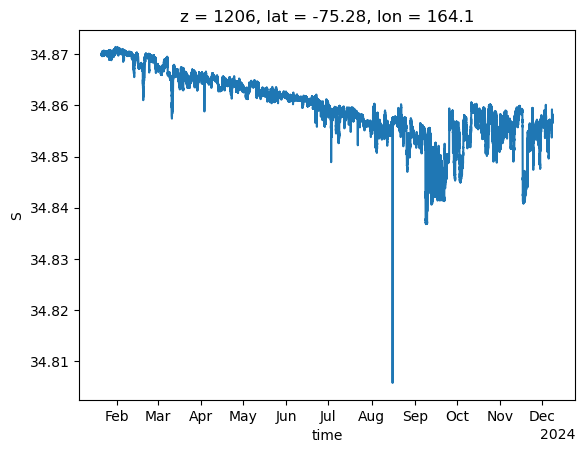

In [21]:
fig = plt.figure()
DITD_2024_ctd_bot.S.plot()

In [22]:
# load in DITD 2018 data - data from online is missing 
# DITD_2018_ctd_top = xr.open_dataset('/Users/mblan/Documents/TNB_Research/data/DITD_2018_2019/sbe_1100.nc')
# DITD_2018_ctd_bot = xr.open_dataset('/Users/mblan/Documents/TNB_Research/data/DITD_2018_2019/sbe_1200.nc')

# DITD_2018_vel_top = xr.open_dataset('/Users/mblan/Documents/TNB_Research/data/DITD_2018_2019/vel_1100.nc')
# DITD_2018_vel_bot = xr.open_dataset('/Users/mblan/Documents/TNB_Research/data/DITD_2018_2019/vel_1200.nc')

In [23]:
# FIX TIME ON DITD veloctiy top sensor 
# DITD_2018_vel_top['time'] = DITD_2018_vel_top.time - pd.Timedelta(12,'h')

In [24]:
DITD_datasets = [
    DITD_2017_vel_bot,
    DITD_2017_ctd_bot,
    DITD_2018_vel_top,
    DITD_2018_vel_bot,
    DITD_2018_ctd_top,
    DITD_2018_ctd_bot,
    DITD_2019_vel_bot,
    DITD_2019_ctd_bot,
    DITD_2020_vel_bot,
    DITD_2020_ctd_bot,
    DITD_2022_vel_bot,
    DITD_2022_ctd_bot,
    DITD_2024_vel_bot,
    DITD_2024_ctd_bot
]

#### Load TNBD data /

In [25]:
df.query("mooring == 'TNBD' ")

,mooring,year,instrument,position,depth,variables,time_start,time_end,sampling_period,n_points
158,TNBD,2018,ctd,bot,1093,"[temp, pressure, absolute_salinity, conservati...",2018-03-13 00:01:43,2019-01-04 23:58:43,0 days 00:03:00,143040.0
159,TNBD,2018,ctd,top,999,"[temp, pressure, absolute_salinity, conservati...",2018-03-13 00:00:43,2019-01-04 23:59:43,0 days 00:01:00,429120.0
160,TNBD,2018,vel,bot,1093,"[east, north, up, pressure_dbar, pressure, spe...",2018-03-12 00:00:00,2019-01-03 23:59:54,0 days 00:15:00,28610.0
161,TNBD,2018,vel,top,999,"[east, north, up, pressure_dbar, pressure, spe...",2018-03-13 00:00:00,2019-01-03 23:30:00,0 days 00:30:00,14256.0


In [26]:
TNBD_ctd_top = dt['TNBD']['2018']['ctd']['top'].to_dataset()
TNBD_ctd_bot = dt['TNBD']['2018']['ctd']['bot'].to_dataset()
TNBD_vel_top = dt['TNBD']['2018']['vel']['top'].to_dataset()
TNBD_vel_bot = dt['TNBD']['2018']['vel']['bot'].to_dataset()

In [27]:
TNBD_datasets = [
    TNBD_ctd_top,
    TNBD_ctd_bot,
    TNBD_vel_top,
    TNBD_vel_bot
]

### Correct LDEO, DITN, and DITD velocity data for magnetic declination 

In [28]:
def rotate_velocity(u,v,angle):
    """Function that rotates velocity component vectors using rotation equations
       
       Inputs: v: u velocity, v velocity, angle: angle between vectors [radians]
       Outputs: rotated v velocity vectors 
    """
    u_prime = u*np.cos(angle) - v*np.sin(angle)
    v_prime = u*np.sin(angle) + v*np.cos(angle)
    
    return u_prime,v_prime

In [29]:
# example on how to correct using above function 
# correct velocity data for magnetic declination 
# magnetic declination for DITD mooring location: 136.398985904
# mag_correction_degrees = 136.39896
# mag_correction_radians = np.deg2rad(mag_correction_degrees)
# u_prime_1100,v_prime_1100 = rotate_velocity(vel_1100.east,vel_1100.north,-mag_correction_radians)
# u_prime_1200,v_prime_1200 = rotate_velocity(vel_1200.east,vel_1200.north,-mag_correction_radians)

#### LDEO correction 

magnetic delcination angle = 135.37

In [30]:
mag_correction_degrees = 135.37
mag_correction_radians = np.deg2rad(mag_correction_degrees)

In [31]:
# top sensor 
u_prime, v_prime = rotate_velocity(LDEO_vel_top.east,LDEO_vel_top.north,-mag_correction_radians)

LDEO_vel_top['u'] = u_prime
LDEO_vel_top['v'] = v_prime

In [32]:
# mid sensor 
u_prime, v_prime = rotate_velocity(LDEO_vel_mid.east,LDEO_vel_mid.north,-mag_correction_radians)

LDEO_vel_mid['u'] = u_prime
LDEO_vel_mid['v'] = v_prime

In [33]:
# bot sensor 
u_prime, v_prime = rotate_velocity(LDEO_vel_bot.east,LDEO_vel_bot.north,-mag_correction_radians)

LDEO_vel_bot['u'] = u_prime
LDEO_vel_bot['v'] = v_prime

In [34]:
# awac sensor 
u_prime, v_prime = rotate_velocity(LDEO_awac.east,LDEO_awac.north,-mag_correction_radians)

LDEO_awac['u'] = u_prime
LDEO_awac['v'] = v_prime

#### DITD Correction SKIP FOR NOW 

magnetic delcination angle = 136.46

Note: correcting all datasets for all years using this angle for now - need to go back and get magnetic declination angle for each year to be more precise since the angle does change yearly (slight change)


In [ ]:
# DITD_datasets = [
#     DITD_2017_vel_bot,
#     DITD_2017_ctd_bot,
#     DITD_2018_vel_top,
#     DITD_2018_vel_bot,
#     DITD_2018_ctd_top,
#     DITD_2018_ctd_bot,
#     DITD_2019_vel_bot,
#     DITD_2019_ctd_bot,
#     DITD_2020_vel_bot,
#     DITD_2020_ctd_bot,
#     DITD_2022_vel_bot,
#     DITD_2022_ctd_bot,
#     DITD_2024_vel_bot,
#     DITD_2024_ctd_bot
# ]

In [57]:
mag_correction_degrees = 136.46
mag_correction_radians = np.deg2rad(mag_correction_degrees)

In [234]:
# 2018 is already corrected for 
# 2017
u_prime, v_prime = rotate_velocity(DITD_2017_vel_bot.u,DITD_2017_vel_bot.v,-mag_correction_radians)

DITD_2017_vel_bot['u'] = u_prime
DITD_2017_vel_bot['v'] = v_prime

In [233]:
u_prime, v_prime = rotate_velocity(DITD_2018_vel_bot.u,DITD_2018_vel_bot.v,-mag_correction_radians)

DITD_2018_vel_bot['u'] = u_prime
DITD_2018_vel_bot['v'] = v_prime

In [235]:
# 2019
u_prime, v_prime = rotate_velocity(DITD_2019_vel_bot.u,DITD_2019_vel_bot.v,-mag_correction_radians)

DITD_2019_vel_bot['u'] = u_prime
DITD_2019_vel_bot['v'] = v_prime

In [236]:
# 2020
u_prime, v_prime = rotate_velocity(DITD_2020_vel_bot.u,DITD_2020_vel_bot.v,-mag_correction_radians)

DITD_2020_vel_bot['u'] = u_prime
DITD_2020_vel_bot['v'] = v_prime

In [237]:
# 2022
u_prime, v_prime = rotate_velocity(DITD_2022_vel_bot.u,DITD_2022_vel_bot.v,-mag_correction_radians)

DITD_2022_vel_bot['u'] = u_prime
DITD_2022_vel_bot['v'] = v_prime

In [238]:
# 2024
u_prime, v_prime = rotate_velocity(DITD_2024_vel_bot.u,DITD_2024_vel_bot.v,-mag_correction_radians)

DITD_2024_vel_bot['u'] = u_prime
DITD_2024_vel_bot['v'] = v_prime

In [239]:
DITD_datasets

[<xarray.Dataset> Size: 5MB
 Dimensions:  (time: 37488)
 Coordinates:
   * time     (time) datetime64[ns] 300kB 2017-02-08T20:30:00 ... 2018-03-06T0...
     z        int64 8B 1239
     lat      float64 8B -75.28
     lon      float64 8B 164.1
 Data variables: (12/15)
     dirt     (time) float64 300kB ...
     spe      (time) float64 300kB ...
     T        (time) float64 300kB ...
     P        (time) float64 300kB ...
     hdgt     (time) float64 300kB ...
     pitch    (time) float64 300kB ...
     ...       ...
     w        (time) float64 300kB ...
     volt     (time) float64 300kB ...
     amp1     (time) float64 300kB ...
     amp2     (time) int64 300kB ...
     amp3     (time) int64 300kB ...
     dep      (time) float64 300kB ...
 Attributes:
     description:  Mooring DITD 1702 AQD,
 <xarray.Dataset> Size: 16MB
 Dimensions:  (time: 281162)
 Coordinates:
   * time     (time) datetime64[ns] 2MB 2017-02-08T20:28:00 ... 2018-03-06T08:...
     z        int64 8B 1225
     lat    

#### DITN correction SKIP FOR NOW 

magnetic declination angle = 135.76

In [ ]:
DITN_datasets = [
    DITN_2014_speed_top,
    DITN_2014_speed_mid,
    DITN_2014_speed_bot,
    DITN_2014_ctd_top,
    DITN_2014_ctd_mid,
    DITN_2014_ctd_bot,
    DITN_2014_temp_top,
    DITN_2014_temp_mid1,
    DITN_2014_temp_mid2,
    DITN_2014_temp_bot,
    DITN_2015_ctd_top,
    DITN_2015_ctd_mid,
    DITN_2015_ctd_bot,
    DITN_2015_speed_top,
    DITN_2015_speed_mid,
    DITN_2015_speed_bot,
    DITN_2015_temp_top,
    DITN_2015_temp_mid1,
    DITN_2015_temp_mid2,
    DITN_2015_temp_bot,
    DITN_2017_vel_top,
    DITN_2017_vel_mid,
    DITN_2017_vel_bot,
    DITN_2017_speed_top,
    DITN_2017_speed_mid,
    DITN_2017_speed_bot,
    DITN_2017_ctd_top,
    DITN_2017_ctd_mid,
    DITN_2017_ctd_bot,
    DITN_2017_temp_top,
    DITN_2017_temp_mid,
    DITN_2017_temp_bot,
    DITN_2018_ctd_top,
    DITN_2018_ctd_mid,
    DITN_2018_ctd_bot,
    DITN_2018_temp_top,
    DITN_2018_temp_mid1,
    DITN_2018_temp_mid2,
    DITN_2018_temp_bot,
    DITN_2018_vel_top,
    DITN_2018_vel_mid,
    DITN_2018_vel_bot,
    DITN_2019_vel_top,
    DITN_2019_vel_mid,
    DITN_2019_vel_bot,
    DITN_2019_ctd_top,
    DITN_2019_ctd_mid,
    DITN_2019_temp_top,
]

In [56]:
DITN_2017_vel_top

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 37484)
Coordinates:
  * time     (time) datetime64[ns] 300kB 2017-02-09T01:15:00 ... 2018-03-06T1...
    z        int64 8B 76
    lat      float64 8B -75.36
    lon      float64 8B 164.7
Data variables: (12/14)
    dirt     (time) float64 300kB ...
    spe      (time) float64 300kB ...
    T        (time) float64 300kB ...
    P        (time) float64 300kB ...
    hdgt     (time) float64 300kB ...
    pitch    (time) float64 300kB ...
    ...       ...
    v        (time) float64 300kB ...
    w        (time) float64 300kB ...
    volt     (time) float64 300kB ...
    amp1     (time) float64 300kB ...
    amp2     (time) float64 300kB ...
    amp3     (time) float64 300kB ...
Attributes:
    description:  Mooring DITN 1702 AQD

In [58]:
mag_correction_degrees = 135.76
mag_correction_radians = np.deg2rad(mag_correction_degrees)

In [59]:
# 2018 is already corrected for 
# 2017
u_prime, v_prime = rotate_velocity(DITN_2017_vel_top.u,DITN_2017_vel_top.v,-mag_correction_radians)

DITN_2017_vel_top['u'] = u_prime
DITN_2017_vel_top['v'] = v_prime

u_prime, v_prime = rotate_velocity(DITN_2017_vel_mid.u,DITN_2017_vel_mid.v,-mag_correction_radians)

DITN_2017_vel_mid['u'] = u_prime
DITN_2017_vel_mid['v'] = v_prime

u_prime, v_prime = rotate_velocity(DITN_2017_vel_bot.u,DITN_2017_vel_bot.v,-mag_correction_radians)

DITN_2017_vel_bot['u'] = u_prime
DITN_2017_vel_bot['v'] = v_prime

In [60]:
# 2018 is already corrected for 
# 2017
u_prime, v_prime = rotate_velocity(DITN_2018_vel_top.u,DITN_2018_vel_top.v,-mag_correction_radians)

DITN_2018_vel_top['u'] = u_prime
DITN_2018_vel_top['v'] = v_prime

u_prime, v_prime = rotate_velocity(DITN_2018_vel_mid.u,DITN_2018_vel_mid.v,-mag_correction_radians)

DITN_2018_vel_mid['u'] = u_prime
DITN_2018_vel_mid['v'] = v_prime

u_prime, v_prime = rotate_velocity(DITN_2018_vel_bot.u,DITN_2018_vel_bot.v,-mag_correction_radians)

DITN_2018_vel_bot['u'] = u_prime
DITN_2018_vel_bot['v'] = v_prime

In [61]:
# 2018 is already corrected for 
# 2019
u_prime, v_prime = rotate_velocity(DITN_2019_vel_top.u,DITN_2019_vel_top.v,-mag_correction_radians)

DITN_2019_vel_top['u'] = u_prime
DITN_2019_vel_top['v'] = v_prime

u_prime, v_prime = rotate_velocity(DITN_2019_vel_mid.u,DITN_2019_vel_mid.v,-mag_correction_radians)

DITN_2019_vel_mid['u'] = u_prime
DITN_2019_vel_mid['v'] = v_prime

u_prime, v_prime = rotate_velocity(DITN_2019_vel_bot.u,DITN_2019_vel_bot.v,-mag_correction_radians)

DITN_2019_vel_bot['u'] = u_prime
DITN_2019_vel_bot['v'] = v_prime

### DITN vs. LDEO 2017/2018

DITN_2018_ctd_top

In [69]:
DITN_2017_ctd_top.z.values, DITN_2017_ctd_mid.z.values, DITN_2017_ctd_bot.z.values

(array(75), array(275), array(675))

In [66]:
LDEO_ctd_bot = LDEO_ctd.sel(depth=360)

In [71]:
LDEO_ctd_bot

<xarray.Dataset> Size: 32MB
Dimensions:                (time: 571394)
Coordinates:
  * time                   (time) datetime64[ns] 5MB 2017-02-01T12:00:01 ... ...
    depth                  int32 4B 360
Data variables:
    temperature_insitu     (time) float64 5MB ...
    potential_temperature  (time) float64 5MB ...
    conductivity           (time) float64 5MB ...
    practical_salinity     (time) float64 5MB ...
    pressure               (time) float64 5MB ...
    sigma0                 (time) float64 5MB ...
Attributes:
    Institution:     Lamont-Doherty Earth Observatory
    Contact:         zappa@ldeo.columbia.edu, ukm2103@columbia.edu
    DOI:             doi:10.7916/a4k3-0a14
    Instrument:      Seabird Electronics SBE 37-SM/P
    Location:        Terra Nova Bay, Antarctica
    Mooring_coords:  74.97° S, 163.96° E
    Units:           Temperature: degrees C, Conductivity: ms/C, Pressure: db...
    Notes:           Sensors at 119 m and 168 m did not measure pressure. Sen...

In [67]:
DITN_2018_ctd_mid

<xarray.Dataset> Size: 5MB
Dimensions:  (time: 85721)
Coordinates:
  * time     (time) datetime64[ns] 686kB 2018-03-12T09:50:00 ... 2019-01-04T0...
    z        int64 8B 274
    lat      float64 8B -75.36
    lon      float64 8B 164.7
Data variables:
    con      (time) float64 686kB ...
    sig_t    (time) float64 686kB ...
    dep      (time) float64 686kB ...
    P        (time) float64 686kB ...
    S        (time) float64 686kB ...
    T        (time) float64 686kB ...
Attributes:
    description:  Mooring DITN 1803 SBE37SM

In [75]:
%matplotlib widget

Text(0.5, 1.0, 'DITN 2017/2018 Salinity')

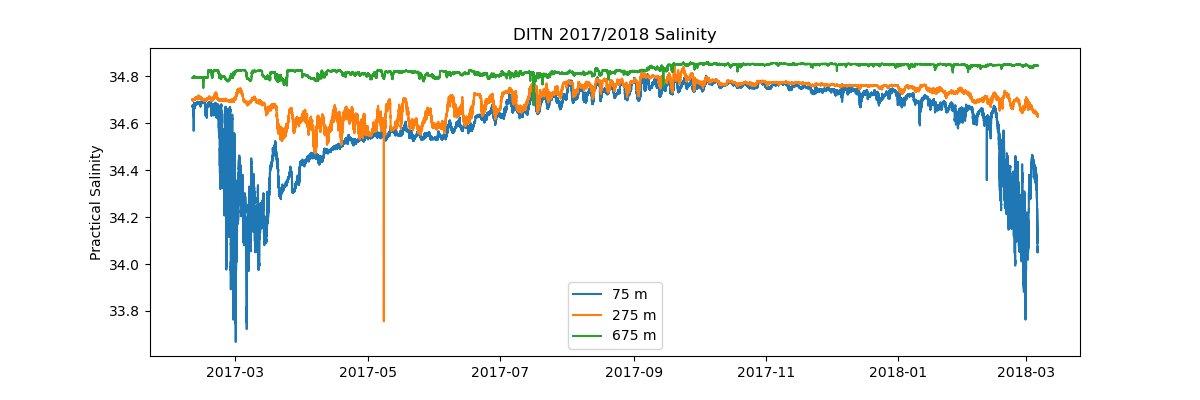

In [81]:
fig = plt.figure(figsize=(12,4))
ds = DITN_2017_ctd_top
ds1 = DITN_2017_ctd_mid
ds2 = DITN_2017_ctd_bot

plt.plot(ds.time,ds.S,label='75 m')
plt.plot(ds1.time,ds1.S,label='275 m')
plt.plot(ds2.time,ds2.S,label='675 m')

plt.legend()
plt.ylabel('Practical Salinity')
plt.title('DITN 2017/2018 Salinity')

In [82]:
LDEO_ctd.depth

<xarray.DataArray 'depth' (depth: 7)> Size: 28B
array([ 47,  95, 119, 144, 168, 219, 360], dtype=int32)
Coordinates:
  * depth    (depth) int32 28B 47 95 119 144 168 219 360

Text(0.5, 1.0, 'LDEO 2017/2018 Salinity')

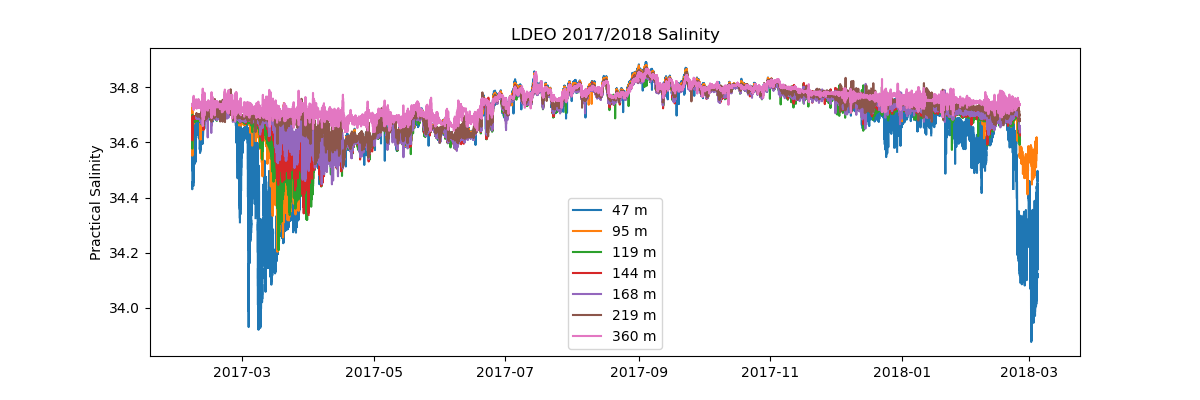

In [84]:
fig = plt.figure(figsize=(12,4))
ds = LDEO_ctd

plt.plot(ds.time,ds.sel(depth=47).practical_salinity,label='47 m')
plt.plot(ds.time,ds.sel(depth=95).practical_salinity,label='95 m')
plt.plot(ds.time,ds.sel(depth=119).practical_salinity,label='119 m')
plt.plot(ds.time,ds.sel(depth=144).practical_salinity,label='144 m')
plt.plot(ds.time,ds.sel(depth=168).practical_salinity,label='168 m')
plt.plot(ds.time,ds.sel(depth=219).practical_salinity,label='219 m')
plt.plot(ds.time,ds.sel(depth=360).practical_salinity,label='360 m')



plt.legend()
plt.ylabel('Practical Salinity')
plt.title('LDEO 2017/2018 Salinity')

Text(0.5, 1.0, 'LDEO and DITN Bottom Salinity')

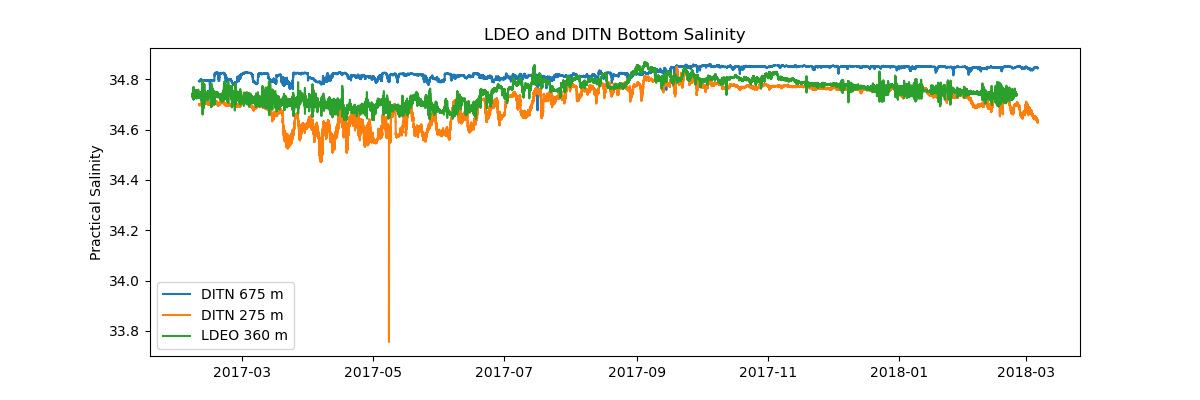

In [86]:
# time series plots 
ds = DITN_2017_ctd_bot
ds1 = LDEO_ctd_bot
ds2 = DITN_2017_ctd_mid
fig = plt.figure(figsize=(12,4))
plt.plot(ds.time,ds.S,label='DITN 675 m')
plt.plot(ds2.time,ds2.S,label='DITN 275 m')
plt.plot(ds1.time,ds1.practical_salinity,label='LDEO 360 m')

plt.legend()
plt.ylabel('Practical Salinity')
plt.title('LDEO and DITN Bottom Salinity')

In [138]:
# create merged DITN mid and bottom sensor datasets 
df.query("mooring == 'DITN' & position == 'mid' & instrument == 'ctd'")

,mooring,year,instrument,position,depth,variables,time_start,time_end,sampling_period,n_points
70,DITN,2014,ctd,mid,278,"[con, T, P, dep, S, sig_t]",2014-12-12 14:00:00,2015-12-10 07:20:00,0 days 00:10:00,52233.0
80,DITN,2015,ctd,mid,275,"[con, T, P, dep, S, sig_t]",2015-12-14 10:30:00,2017-02-08 17:10:00,0 days 00:10:00,60809.0
90,DITN,2017,ctd,mid,275,"[con, T, P, dep, S, sig_t]",2017-02-09 01:00:00,2018-03-06 12:02:00,0 days 00:02:00,281132.0
102,DITN,2018,ctd,mid,274,"[con, sig_t, dep, P, S, T]",2018-03-12 09:50:00,2019-01-04 01:10:00,0 days 00:05:00,85721.0
111,DITN,2019,ctd,mid,271,"[con, T, P, S]",2019-01-07 08:20:00,2020-03-17 05:50:00,0 days 00:02:00,309061.0
121,DITN,2020,ctd,mid,269,"[con, T, P, S]",2020-03-18 09:35:00,2022-03-15 13:55:00,0 days 00:05:00,209429.0


##### Resample DITN data to create one continuous dataset

In [91]:
# need to resample 2017, 2018, and 2020 to 10 minutes 
DITN_2017_ctd_bot = DITN_2017_ctd_bot.resample(time='10min').mean()
DITN_2018_ctd_bot = DITN_2018_ctd_bot.resample(time='10min').mean()
DITN_2020_ctd_bot = DITN_2020_ctd_bot.resample(time='10min').mean()

In [ ]:
# merge datasets together 
DITN_ctd_bot = xr.concat([DITN_2014_ctd_bot,DITN_2015_ctd_bot,DITN_2017_ctd_bot,DITN_2018_ctd_bot,DITN_2020_ctd_bot],dim='time')

# make full time index to fill in with nans where time is missing - aids in plotting later 
full_time = pd.date_range(
    start="2014-12-12T14:00:00",
    end="2022-03-15T13:50:00",
    freq="10min"
)

DITN_ctd_bot = DITN_ctd_bot.sortby("time")     # VERY important after concatenation
DITN_ctd_bot = DITN_ctd_bot.reindex(time=full_time)



C:\Users\mblan\AppData\Local\Temp\ipykernel_6668\3122996120.py:2: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  DITN_ctd_bot = xr.concat([DITN_2014_ctd_bot,DITN_2015_ctd_bot,DITN_2017_ctd_bot,DITN_2018_ctd_bot,DITN_2020_ctd_bot],dim='time')


In [117]:
# DITN mid
DITN_2017_ctd_mid = DITN_2017_ctd_mid.resample(time='10min').mean()
DITN_2018_ctd_mid = DITN_2018_ctd_mid.resample(time='10min').mean()
DITN_2019_ctd_mid = DITN_2019_ctd_mid.resample(time='10min').mean()
DITN_2020_ctd_mid = DITN_2020_ctd_mid.resample(time='10min').mean()

In [118]:
# merge datasets together 
DITN_ctd_mid = xr.concat([DITN_2014_ctd_mid,DITN_2015_ctd_mid,DITN_2017_ctd_mid,DITN_2018_ctd_mid,DITN_2019_ctd_mid,DITN_2020_ctd_mid],dim='time')

C:\Users\mblan\AppData\Local\Temp\ipykernel_6668\61656509.py:2: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  DITN_ctd_mid = xr.concat([DITN_2014_ctd_mid,DITN_2015_ctd_mid,DITN_2017_ctd_mid,DITN_2018_ctd_mid,DITN_2019_ctd_mid,DITN_2020_ctd_mid],dim='time')


In [120]:
DITN_ctd_mid.time[-1]

<xarray.DataArray 'time' ()> Size: 8B
array('2022-03-15T13:50:00.000000000', dtype='datetime64[ns]')
Coordinates:
    z        int64 8B 269
    time     datetime64[ns] 8B 2022-03-15T13:50:00
    lat      float64 8B -75.35
    lon      float64 8B 164.8

In [121]:
# make full time index to fill in with nans where time is missing - aids in plotting later 
full_time = pd.date_range(
    start="2014-12-12T14:00:00",
    end="2022-03-15T13:50:00",
    freq="10min"
)

DITN_ctd_mid = DITN_ctd_mid.sortby("time")     # VERY important after concatenation
DITN_ctd_mid = DITN_ctd_mid.reindex(time=full_time)

In [123]:
# DITN top 
DITN_2017_ctd_top = DITN_2017_ctd_top.resample(time='10min').mean()
DITN_2018_ctd_top = DITN_2018_ctd_top.resample(time='10min').mean()
DITN_2019_ctd_top = DITN_2019_ctd_top.resample(time='10min').mean()

In [124]:
DITN_ctd_top = xr.concat([DITN_2014_ctd_top,DITN_2015_ctd_top,DITN_2017_ctd_top,DITN_2018_ctd_top,DITN_2019_ctd_top],dim='time')

C:\Users\mblan\AppData\Local\Temp\ipykernel_6668\952636115.py:1: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  DITN_ctd_top = xr.concat([DITN_2014_ctd_top,DITN_2015_ctd_top,DITN_2017_ctd_top,DITN_2018_ctd_top,DITN_2019_ctd_top],dim='time')


In [126]:
DITN_ctd_top.time[-1]

<xarray.DataArray 'time' ()> Size: 8B
array('2020-03-17T05:50:00.000000000', dtype='datetime64[ns]')
Coordinates:
    z        int64 8B 71
    time     datetime64[ns] 8B 2020-03-17T05:50:00
    lat      float64 8B -75.35
    lon      float64 8B 164.8

In [135]:
# make full time index to fill in with nans where time is missing - aids in plotting later 
full_time = pd.date_range(
    start="2014-12-12T14:00:00",
    end="2020-03-17T05:50:00",
    freq="10min"
)

DITN_ctd_top = DITN_ctd_top.sortby("time")     # VERY important after concatenation
DITN_ctd_top = DITN_ctd_top.reindex(time=full_time)

Text(0.5, 1.0, 'DITN Salinity')

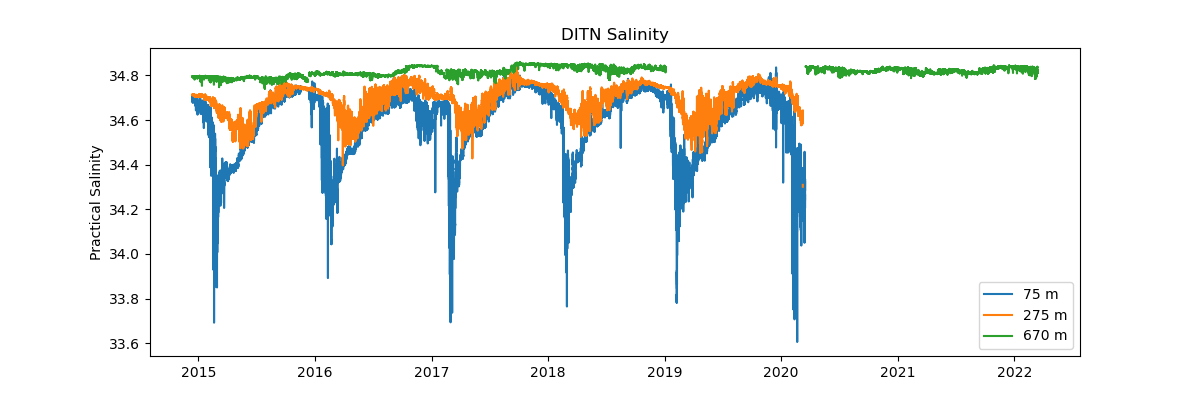

In [136]:
fig = plt.figure(figsize=(12,4))
plt.plot(DITN_ctd_top.time,DITN_ctd_top.S,label='75 m')
plt.plot(DITN_ctd_mid.time,DITN_ctd_mid.S,label='275 m')
plt.plot(DITN_ctd_bot.time,DITN_ctd_bot.S,label='670 m')
plt.legend()
plt.ylabel('Practical Salinity')
plt.title('DITN Salinity')

<>:47: SyntaxWarning: invalid escape sequence '\c'
<>:47: SyntaxWarning: invalid escape sequence '\c'
C:\Users\mblan\AppData\Local\Temp\ipykernel_6668\1227232865.py:47: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('Potential Temperature [$^\circ$C]')
C:\Users\mblan\AppData\Local\Temp\ipykernel_6668\1227232865.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("jet", len(unique_years))


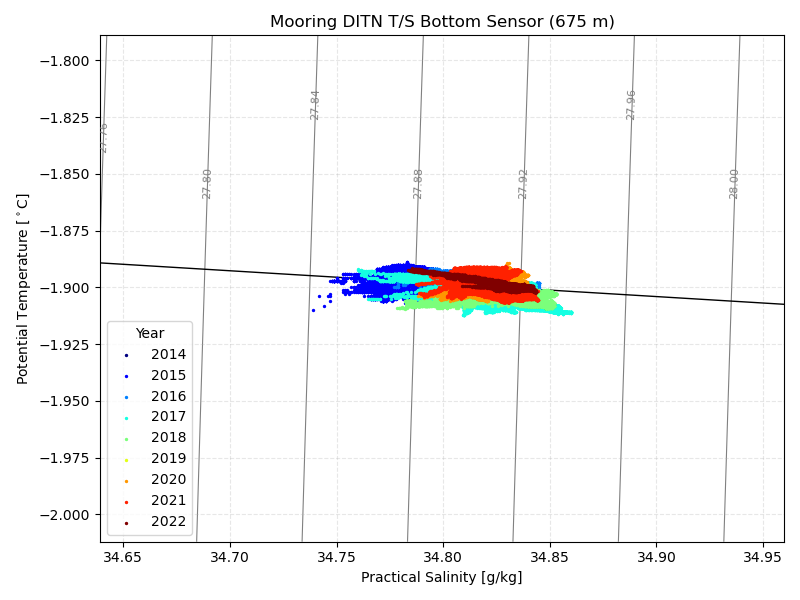

In [133]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gsw

# Extract variables
temp = DITN_ctd_bot.T
sal  = DITN_ctd_bot.S
time = pd.to_datetime(DITN_ctd_bot.time.values)
years = time.year
unique_years = np.unique(years)

# ----- Density Grid -----
mint = temp.min()
maxt = temp.max()
mins = sal.min()
maxs = sal.max()

tempL = np.linspace(mint.values - 0.1, maxt.values + 0.1, 200)
salL  = np.linspace(mins.values - 0.1, maxs.values + 0.1, 200)
Tg, Sg = np.meshgrid(tempL, salL)

sigma_theta = gsw.sigma0(Sg, Tg)

# ----- Make Figure -----
fig, ax = plt.subplots(figsize=(8,6))

# Density contours
cs = ax.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1, linewidths=0.8)
cl = plt.clabel(cs, fontsize=8, inline=False)

# ----- Scatter by Year -----
# cmap = plt.cm.get_cmap("tab20", len(unique_years))
cmap = plt.cm.get_cmap("jet", len(unique_years))

for i, yr in enumerate(unique_years):
    idx = (years == yr)
    ax.scatter(sal[idx], temp[idx], s=2, color=cmap(i),
               label=str(yr), zorder=3)

# ----- Freezing Temperature Line -----
t_freezing = gsw.t_freezing(salL, p=0, saturation_fraction=0)
ax.plot(salL, t_freezing, color='black', linewidth=1, zorder=2)

# ----- Labels + Decorations -----
ax.set_xlabel('Practical Salinity [g/kg]')
ax.set_ylabel('Potential Temperature [$^\circ$C]')
ax.set_title('Mooring DITN T/S Bottom Sensor (675 m)')

ax.legend(title="Year")
ax.grid(True, linestyle='--', alpha=0.3)
ax.tick_params(direction='out')

plt.tight_layout()
plt.show()

<>:47: SyntaxWarning: invalid escape sequence '\c'
<>:47: SyntaxWarning: invalid escape sequence '\c'
C:\Users\mblan\AppData\Local\Temp\ipykernel_6668\1651419969.py:47: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('Potential Temperature [$^\circ$C]')
C:\Users\mblan\AppData\Local\Temp\ipykernel_6668\1651419969.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("jet", len(unique_years))


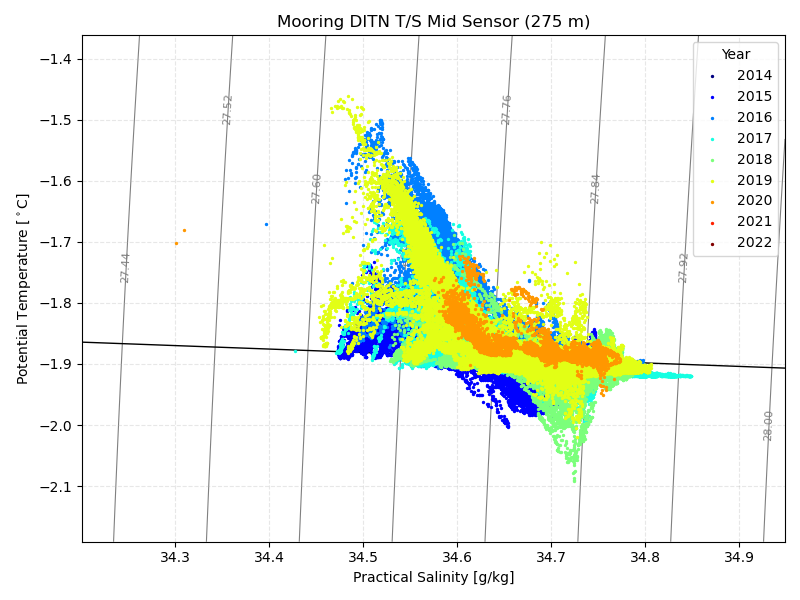

In [175]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gsw

# Extract variables
temp = DITN_ctd_mid.T
sal  = DITN_ctd_mid.S
time = pd.to_datetime(DITN_ctd_mid.time.values)
years = time.year
unique_years = np.unique(years)

# ----- Density Grid -----
mint = temp.min()
maxt = temp.max()
mins = sal.min()
maxs = sal.max()

tempL = np.linspace(mint.values - 0.1, maxt.values + 0.1, 200)
salL  = np.linspace(mins.values - 0.1, maxs.values + 0.1, 200)
Tg, Sg = np.meshgrid(tempL, salL)

sigma_theta = gsw.sigma0(Sg, Tg)

# ----- Make Figure -----
fig, ax = plt.subplots(figsize=(8,6))

# Density contours
cs = ax.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1, linewidths=0.8)
cl = plt.clabel(cs, fontsize=8, inline=False)

# ----- Scatter by Year -----
# cmap = plt.cm.get_cmap("tab20", len(unique_years))
cmap = plt.cm.get_cmap("jet", len(unique_years))

for i, yr in enumerate(unique_years):
    idx = (years == yr)
    ax.scatter(sal[idx], temp[idx], s=2, color=cmap(i),
               label=str(yr), zorder=3)

# ----- Freezing Temperature Line -----
t_freezing = gsw.t_freezing(salL, p=0, saturation_fraction=0)
ax.plot(salL, t_freezing, color='black', linewidth=1, zorder=2)

# ----- Labels + Decorations -----
ax.set_xlabel('Practical Salinity [g/kg]')
ax.set_ylabel('Potential Temperature [$^\circ$C]')
ax.set_title('Mooring DITN T/S Mid Sensor (275 m)')

ax.legend(title="Year")
ax.grid(True, linestyle='--', alpha=0.3)
ax.tick_params(direction='out')

plt.tight_layout()
plt.show()

<>:47: SyntaxWarning: invalid escape sequence '\c'
<>:47: SyntaxWarning: invalid escape sequence '\c'
C:\Users\mblan\AppData\Local\Temp\ipykernel_6668\229218918.py:47: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('Potential Temperature [$^\circ$C]')
C:\Users\mblan\AppData\Local\Temp\ipykernel_6668\229218918.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("jet", len(unique_years))


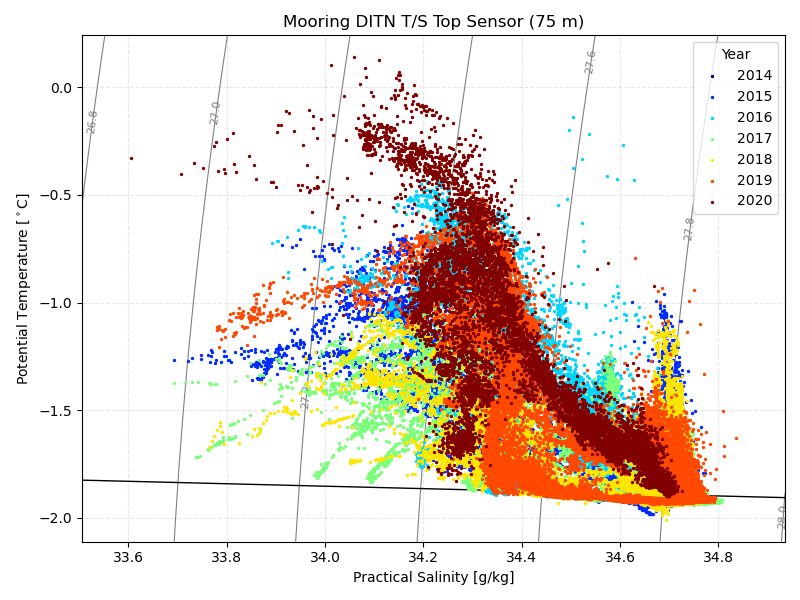

In [180]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gsw

# Extract variables
temp = DITN_ctd_top.T
sal  = DITN_ctd_top.S
time = pd.to_datetime(DITN_ctd_top.time.values)
years = time.year
unique_years = np.unique(years)

# ----- Density Grid -----
mint = temp.min()
maxt = temp.max()
mins = sal.min()
maxs = sal.max()

tempL = np.linspace(mint.values - 0.1, maxt.values + 0.1, 200)
salL  = np.linspace(mins.values - 0.1, maxs.values + 0.1, 200)
Tg, Sg = np.meshgrid(tempL, salL)

sigma_theta = gsw.sigma0(Sg, Tg)

# ----- Make Figure -----
fig, ax = plt.subplots(figsize=(8,6))

# Density contours
cs = ax.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1, linewidths=0.8)
cl = plt.clabel(cs, fontsize=8, inline=False)

# ----- Scatter by Year -----
# cmap = plt.cm.get_cmap("tab20", len(unique_years))
cmap = plt.cm.get_cmap("jet", len(unique_years))

for i, yr in enumerate(unique_years):
    idx = (years == yr)
    ax.scatter(sal[idx], temp[idx], s=2, color=cmap(i),
               label=str(yr), zorder=3)

# ----- Freezing Temperature Line -----
t_freezing = gsw.t_freezing(salL, p=0, saturation_fraction=0)
ax.plot(salL, t_freezing, color='black', linewidth=1, zorder=2)

# ----- Labels + Decorations -----
ax.set_xlabel('Practical Salinity [g/kg]')
ax.set_ylabel('Potential Temperature [$^\circ$C]')
ax.set_title('Mooring DITN T/S Top Sensor (75 m)')

ax.legend(title="Year")
ax.grid(True, linestyle='--', alpha=0.3)
ax.tick_params(direction='out')

plt.tight_layout()
plt.show()

In [141]:
df.query("mooring == 'DITD'& instrument == 'ctd'")

,mooring,year,instrument,position,depth,variables,time_start,time_end,sampling_period,n_points
55,DITD,2017,ctd,bot,1225,"[con, T, P, dep, S, sig_t]",NaT,NaT,NaT,NaN
57,DITD,2018,ctd,bot,1218,"[con, T, P, dep, S, sig_t]",NaT,NaT,NaT,NaN
58,DITD,2018,ctd,top,1122,"[con, T, P, dep, S, sig_t]",NaT,NaT,NaT,NaN
61,DITD,2019,ctd,bot,1219,"[con, T, P, S]",NaT,NaT,NaT,NaN
63,DITD,2020,ctd,bot,1218,"[con, T, P, S]",NaT,NaT,NaT,NaN
65,DITD,2022,ctd,bot,1205,"[T, P, dep, con, S, sig_t]",NaT,NaT,NaT,NaN
67,DITD,2024,ctd,bot,1206,"[Density, con, sig_t, depth, P, S, T]",NaT,NaT,NaT,NaN


In [152]:
# 2 min sampling interval for DITD 2017
# 3 min sampling interval for DITD 2018
# 2 min samplin interval for DITD 2019
# 5 min sampling interval for DITD 2020
# 5 min sampling interval for DITD 2022
# 5 min sampling interval for 2024 

In [40]:
# USING TOP DITD FOR NOW FOR 2018 
# NEED TO WAIT TO HEAR BACK FROM LIV ABOUT ISSUE WITH BOTTOM CTD SENSOR IN 2018
DITD_2018_ctd_bot = dt['DITD']['2018']['ctd']['top'].to_dataset()
DITD_2018_ctd_bot = DITD_2018_ctd_bot.rename({'DateTime':'time'})

In [ ]:
# DITD_2017_ctd_bot = DITD_2017_ctd_bot.resample(time='5min').mean()
# DITD_2018_ctd_bot = DITD_2018_ctd_bot.resample(time='5min').mean()
# DITD_2019_ctd_bot = DITD_2019_ctd_bot.resample(time='5min').mean()

In [189]:
# DITD_2018_ctd_bot = DITD_2018_ctd_bot.drop_vars(['absolute_salinity','density','conservative_temp'])

In [190]:
# DITD_2018_ctd_bot = DITD_2018_ctd_bot.rename({
#     "temp": "T",
#     "practical_salinity":"S",
#     "pressure":"P"
# })

In [191]:
# DITD_2018_ctd_bot = DITD_2018_ctd_bot.assign_coords(
#     z=1218,
#     lat=-72.28,
#     lon=164.1
# )

In [307]:
df.query("mooring == 'DITS'")

,mooring,year,instrument,position,depth,variables,time_start,time_end,sampling_period,n_points
129,DITS,2017,ctd,bot,1088,"[con, T, P, dep, S, sig_t]",2017-02-12 12:00:00,2018-03-08 14:10:00,0 days 00:05:00,112059.0
130,DITS,2017,ctd,mid,383,"[con, T, P, dep, S, sig_t]",2017-02-12 12:00:00,2018-03-08 14:10:00,0 days 00:05:00,112059.0
131,DITS,2017,ctd,top,192,"[con, T, P, dep, S, sig_t]",2017-02-12 12:00:00,2018-03-08 14:10:00,0 days 00:05:00,112059.0
132,DITS,2017,speed,bot,1087,"[dirt, spe]",2017-02-12 13:00:00,2018-03-08 14:00:00,0 days 01:00:00,9338.0
133,DITS,2017,speed,mid,384,"[dirt, spe]",2017-02-12 13:00:00,2018-03-08 14:00:00,0 days 01:00:00,9338.0
134,DITS,2017,speed,top,191,"[dirt, spe]",2017-02-12 13:00:00,2018-03-08 14:00:00,0 days 01:00:00,9338.0
135,DITS,2017,temp,bot,353,[T],2017-02-12 12:00:00,2017-11-10 19:43:20,0 days 00:00:10,2344221.0
136,DITS,2017,temp,mid1,273,[T],2017-02-12 12:00:00,2017-11-10 19:43:20,0 days 00:00:10,2344221.0
137,DITS,2017,temp,mid2,313,[T],2017-02-12 12:00:00,2017-11-10 19:43:20,0 days 00:00:10,2344221.0
138,DITS,2017,temp,top,233,[T],2017-02-12 12:00:00,2017-11-10 19:43:20,0 days 00:00:10,2344221.0


In [41]:
DITD_ctd_bot = xr.concat([DITD_2017_ctd_bot,DITD_2018_ctd_bot,DITD_2019_ctd_bot,DITD_2020_ctd_bot,DITD_2022_ctd_bot,DITD_2024_ctd_bot],dim='time')

C:\Users\mblan\AppData\Local\Temp\ipykernel_67988\3137713427.py:1: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  DITD_ctd_bot = xr.concat([DITD_2017_ctd_bot,DITD_2018_ctd_bot,DITD_2019_ctd_bot,DITD_2020_ctd_bot,DITD_2022_ctd_bot,DITD_2024_ctd_bot],dim='time')


In [42]:
DITD_ctd_bot.time[-1]

<xarray.DataArray 'time' ()> Size: 8B
array('2024-12-08T08:20:00.000000000', dtype='datetime64[ns]')
Coordinates:
    z        int64 8B 1206
    time     datetime64[ns] 8B 2024-12-08T08:20:00
    lat      float64 8B -75.28
    lon      float64 8B 164.1

In [43]:
# make full time index to fill in with nans where time is missing - aids in plotting later 
full_time = pd.date_range(
    start="2017-02-08T20:20:00",
    end="2024-12-08T08:20:00",
    freq="10min"
)

DITD_ctd_bot = DITD_ctd_bot.sortby("time")     # VERY important after concatenation
DITD_ctd_bot = DITD_ctd_bot.reindex(time=full_time)

In [74]:
dt['TNBD']['2018']['vel']['top'].lon.values

array(165.5562)

Text(0.5, 1.0, 'DITD 1200 m Salinity')

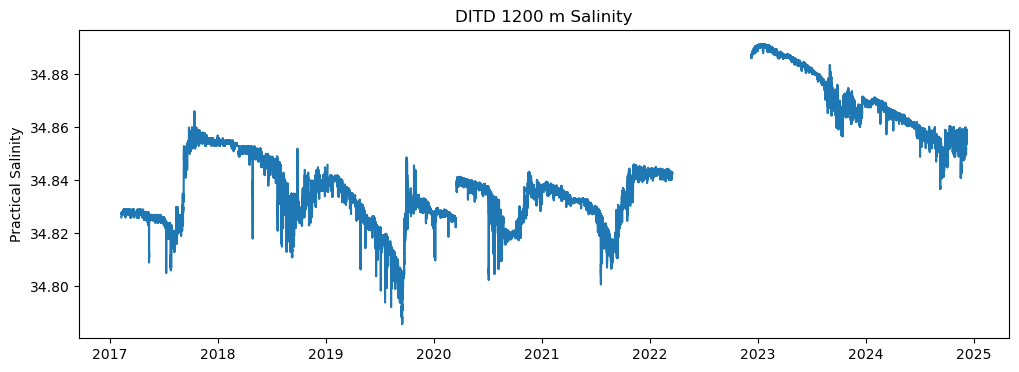

In [44]:
fig = plt.figure(figsize=(12,4))
plt.plot(DITD_ctd_bot.time,DITD_ctd_bot.S)
plt.ylabel('Practical Salinity')
plt.title('DITD 1200 m Salinity')

Text(0, 0.5, 'Potential Temperature [°C]')

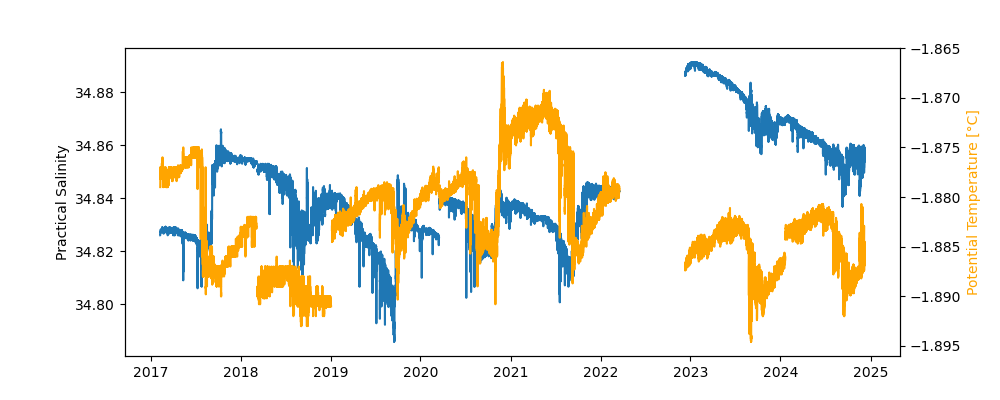

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(DITD_ctd_bot.time,DITD_ctd_bot.S)
ax.set_ylabel('Practical Salinity')

ax1 = ax.twinx()
ax1.plot(DITD_ctd_bot.time,DITD_ctd_bot.T,color='orange')
ax1.set_ylabel('Potential Temperature [°C]',color='orange')


<>:42: SyntaxWarning: invalid escape sequence '\c'
<>:42: SyntaxWarning: invalid escape sequence '\c'
C:\Users\mblan\AppData\Local\Temp\ipykernel_6668\862866304.py:42: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('Potential Temperature [$^\circ$C]')
C:\Users\mblan\AppData\Local\Temp\ipykernel_6668\862866304.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("jet", len(unique_years))


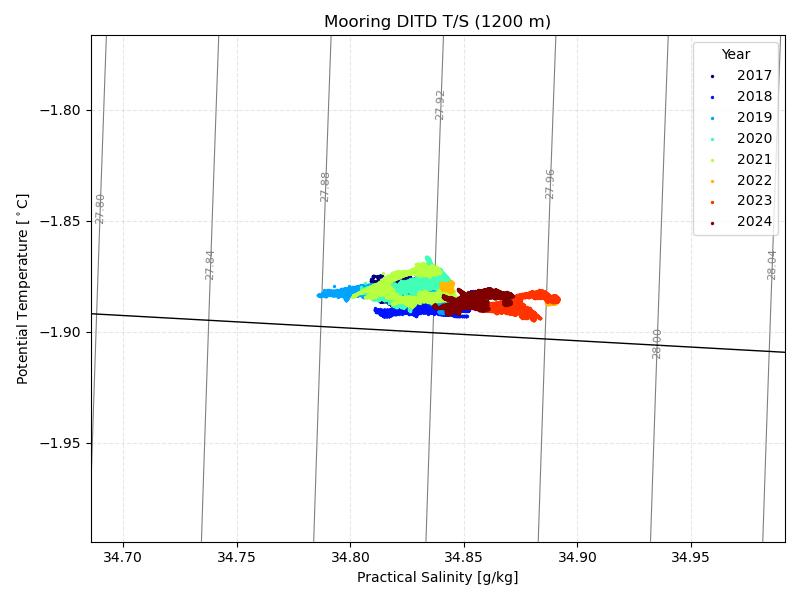

In [201]:


# Extract variables
temp = DITD_ctd_bot.T
sal  = DITD_ctd_bot.S
time = pd.to_datetime(DITD_ctd_bot.time.values)
years = time.year
unique_years = np.unique(years)

# ----- Density Grid -----
mint = temp.min()
maxt = temp.max()
mins = sal.min()
maxs = sal.max()

tempL = np.linspace(mint.values - 0.1, maxt.values + 0.1, 200)
salL  = np.linspace(mins.values - 0.1, maxs.values + 0.1, 200)
Tg, Sg = np.meshgrid(tempL, salL)

sigma_theta = gsw.sigma0(Sg, Tg)

# ----- Make Figure -----
fig, ax = plt.subplots(figsize=(8,6))

# Density contours
cs = ax.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1, linewidths=0.8)
cl = plt.clabel(cs, fontsize=8, inline=False)

# ----- Scatter by Year -----
# cmap = plt.cm.get_cmap("tab20", len(unique_years))
cmap = plt.cm.get_cmap("jet", len(unique_years))

for i, yr in enumerate(unique_years):
    idx = (years == yr)
    ax.scatter(sal[idx], temp[idx], s=2, color=cmap(i),
               label=str(yr), zorder=3)

# ----- Freezing Temperature Line -----
t_freezing = gsw.t_freezing(salL, p=0, saturation_fraction=0)
ax.plot(salL, t_freezing, color='black', linewidth=1, zorder=2)

# ----- Labels + Decorations -----
ax.set_xlabel('Practical Salinity [g/kg]')
ax.set_ylabel('Potential Temperature [$^\circ$C]')
ax.set_title('Mooring DITD T/S (1200 m)')

ax.legend(title="Year")
ax.grid(True, linestyle='--', alpha=0.3)
ax.tick_params(direction='out')

plt.tight_layout()
plt.show()

In [66]:
dt['DITN']['2018']['vel']['top'].u.values

array([ 1.0353,     nan,  5.5713, ..., -0.8326,     nan, -1.2598],
      shape=(57147,))

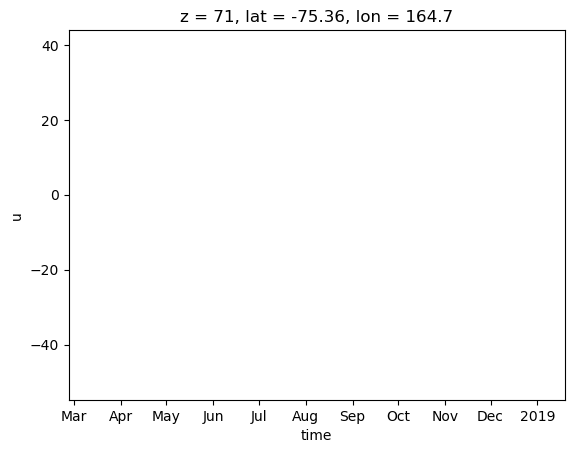

In [64]:
fig = plt.figure()
dt['DITN']['2018']['vel']['bot'].u.plot()
dt['DITN']['2018']['vel']['top'].u.plot()

In [67]:
df.query("mooring == 'D'")

,mooring,year,instrument,position,depth,variables,time_start,time_end,sampling_period,n_points
0,D,2014,ctd,bot,-1069,"[T_0, S_0, S_1, S_2, T_2]",2014-01-22 13:30:00,2016-02-01 17:00:00,0 days 00:30:00,35528.0
1,D,2014,ctd,top,-509,"[S_0, T_0, S_2, S_1, T_2]",2014-01-22 00:00:00,2016-01-31 10:00:00,0 days 00:30:00,35493.0
2,D,2014,temp,mid1,-739,"[T_0, T_2]",2014-01-22 00:00:00,2016-01-31 11:00:00,0 days 00:10:00,106483.0
3,D,2014,temp,mid2,-966,"[T_0, T_2]",2014-01-22 00:00:00,2016-01-31 11:00:00,0 days 00:10:00,106483.0
4,D,2014,vel,bot,-1112,"[U_0, V_0, Mod_0, Dir_0, TiltX, TiltY, Heading...",2014-01-21 01:30:00,2015-05-14 16:00:00,0 days 00:30:00,22974.0
5,D,2014,vel,mid,-875,"[U_0, V_0, Mod_0, Dir_0]",2014-01-20 23:00:00,2016-01-30 10:00:00,0 days 01:00:00,17748.0
6,D,2014,vel,top,-539,"[U_0, V_0, Mod_0, Dir_0]",2014-01-20 23:00:00,2016-01-29 12:00:00,0 days 01:00:00,17726.0
7,D,2016,ctd,bot,-1060,"[Theta_0, S_0, Conductivity]",2016-02-06 22:02:00,2016-05-28 07:47:00,0 days 00:05:00,32086.0
8,D,2016,ctd,top,-523,"[Theta_0, S_0, Conductivity]",2016-02-06 22:05:00,2016-09-14 21:45:00,0 days 00:05:00,63645.0
9,D,2016,temp,mid1,-749,"[T_0, T_2]",2016-02-06 22:06:00,2017-01-08 21:16:00,0 days 00:10:00,48524.0


In [54]:
DITN_vel_top = xr.concat([DITN_2017_vel_top,DITN_2018_vel_top,DITN_2019_vel_top,DITN_2020_vel_top],dim='time')

C:\Users\mblan\AppData\Local\Temp\ipykernel_67988\2822034608.py:1: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  DITN_vel_top = xr.concat([DITN_2017_vel_top,DITN_2018_vel_top,DITN_2019_vel_top,DITN_2020_vel_top],dim='time')


In [55]:
DITN_vel_mid = xr.concat([DITN_2017_vel_mid,DITN_2018_vel_mid,DITN_2019_vel_mid,DITN_2020_vel_mid],dim='time')

C:\Users\mblan\AppData\Local\Temp\ipykernel_67988\502369978.py:1: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  DITN_vel_mid = xr.concat([DITN_2017_vel_mid,DITN_2018_vel_mid,DITN_2019_vel_mid,DITN_2020_vel_mid],dim='time')


In [56]:
DITN_vel_bot = xr.concat([DITN_2017_vel_bot,DITN_2018_vel_bot,DITN_2019_vel_bot,DITN_2020_vel_bot],dim='time')

C:\Users\mblan\AppData\Local\Temp\ipykernel_67988\1558472935.py:1: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  DITN_vel_bot = xr.concat([DITN_2017_vel_bot,DITN_2018_vel_bot,DITN_2019_vel_bot,DITN_2020_vel_bot],dim='time')


### DITD vs. TNBD 

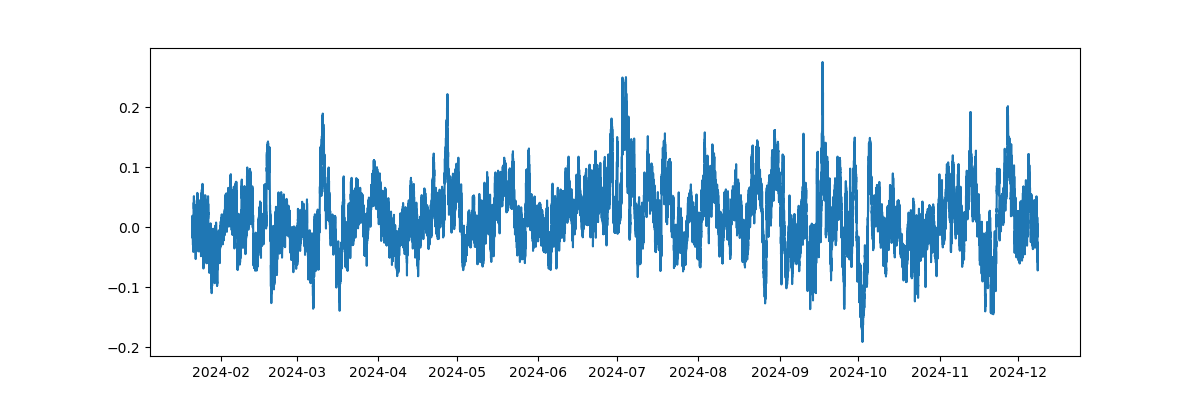

In [282]:
fig = plt.figure(figsize=(12,4))
plt.plot(DITD_2024_vel_bot.time,DITD_2024_vel_bot.u)


In [45]:
# I think velocity units for this year are in m/s not cm/s -> should confirm with Liv 
DITD_2024_vel_bot['u'] = DITD_2024_vel_bot.u *100
DITD_2024_vel_bot['v'] = DITD_2024_vel_bot.v *100

In [ ]:
# DITD_2018_vel_bot = DITD_2018_vel_bot.resample(time='15min').mean()
# DITD_2019_vel_bot = DITD_2019_vel_bot.resample(time='15min').mean()
# DITD_2020_vel_bot = DITD_2020_vel_bot.resample(time='15min').mean()
# DITD_2022_vel_bot = DITD_2022_vel_bot.resample(time='15min').mean()
# DITD_2024_vel_bot = DITD_2024_vel_bot.resample(time='15min').mean()

In [46]:
DITD_vel_bot = xr.concat([DITD_2017_vel_bot,DITD_2018_vel_bot,DITD_2019_vel_bot,DITD_2020_vel_bot,DITD_2022_vel_bot,DITD_2024_vel_bot],dim='time')

C:\Users\mblan\AppData\Local\Temp\ipykernel_67988\858091826.py:1: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  DITD_vel_bot = xr.concat([DITD_2017_vel_bot,DITD_2018_vel_bot,DITD_2019_vel_bot,DITD_2020_vel_bot,DITD_2022_vel_bot,DITD_2024_vel_bot],dim='time')


In [47]:
DITD_vel_bot.time[-1]

<xarray.DataArray 'time' ()> Size: 8B
array('2024-12-08T08:10:00.000000000', dtype='datetime64[ns]')
Coordinates:
    z        int64 8B 1214
    time     datetime64[ns] 8B 2024-12-08T08:10:00
    lat      float64 8B -75.28
    lon      float64 8B 164.1

In [48]:
# full_time = pd.date_range(
#     start="2017-02-08T20:30:00",
#     end="2024-12-08T08:10:00",
#     freq="10min"
# )

DITD_vel_bot = DITD_vel_bot.sortby("time")     # VERY important after concatenation
# DITD_vel_bot = DITD_vel_bot.reindex(time=full_time)

In [49]:
# DITD_2017_vel sampliing freq = 15 min
# 2018 - 10 min 
# 2019 - 10 min 
# 2020 - 10 min 
# 2022 - 10 min 
# 2024 - 10 min 
DITD_2024_vel_bot.time

<xarray.DataArray 'time' (time: 46417)> Size: 371kB
array(['2024-01-21T00:10:00.000000000', '2024-01-21T00:20:00.000000000',
       '2024-01-21T00:30:00.000000000', ..., '2024-12-08T07:50:00.000000000',
       '2024-12-08T08:00:00.000000000', '2024-12-08T08:10:00.000000000'],
      shape=(46417,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 371kB 2024-01-21T00:10:00 ... 2024-12-08T0...
    z        int64 8B 1214
    lat      float64 8B -75.28
    lon      float64 8B 164.1

c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


Text(0, 0.5, 'Velocity (m/s)')

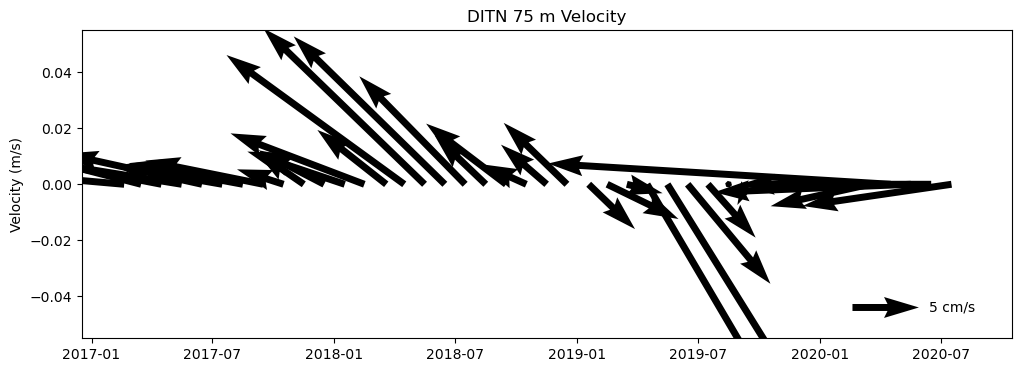

In [59]:
fig = plt.figure(figsize=(12,4))
ds = DITN_vel_top
q = plt.quiver(
    ds.time.resample(time='M').mean().values,np.zeros(len(ds.time.resample(time='M').mean())),
    ds.u.resample(time='M').mean(),
    ds.v.resample(time='M').mean(),
    scale=70, units='width'
)
plt.quiverkey(q, X=0.90, Y=0.1, U=5, label='5 cm/s', labelpos='E')

plt.title('DITN 75 m Velocity')
plt.ylabel('Velocity (m/s)')

In [ ]:
fig, ax = plt.subplots(ncols=1,nrows=2,constrained_layout=True,figsize=(12,6))

q = ax[0].quiver(tnbd_vel1000.time.resample(time='W').mean().values,np.zeros(len(tnbd_vel1000.time.resample(time='W').mean().values)),
               tnbd_vel1000.east.resample(time='W').mean(),
               tnbd_vel1000.north.resample(time='W').mean(),
               tnbd_sbe1000.absolute_salinity.resample(time='W').mean(),scale = 0.75,units='width')

q1 = ax[1].quiver(tnbd_vel1100.time.resample(time='W').mean().values,np.zeros(len(tnbd_vel1100.time.resample(time='W').mean().values)),
               tnbd_vel1100.east.resample(time='W').mean(),
               tnbd_vel1100.north.resample(time='W').mean(),
               tnbd_sbe1100.absolute_salinity.resample(time='W').mean(),scale= 0.75, units='width')

plt.colorbar(q,label='Weekly Averaged Absolute Salinity')
# plt.colorbar(q1,label='Weekly Averaged Absolute Salinity')

ax[0].quiverkey(q, X=0.90, Y=0.1, U=0.05, label='0.05 m/s', labelpos='E')

ax[0].set_title('Weekly Averaged Velocity at TNBD 999 m')
ax[1].set_title('Weekly Averaged Velocity at TNBD 1093 m')
# plt.ylim(-2,2)
ax[0].set_xlim(datetime.datetime(2018, 3, 1),datetime.datetime(2019, 2, 10))
ax[1].set_xlim(datetime.datetime(2018, 3, 1),datetime.datetime(2019, 2, 10))
ax[0].hlines(y=0,xmin=datetime.datetime(2018, 3, 1),
           xmax = datetime.datetime(2019, 2, 10),color='grey',linestyle='dashed')

ax[1].hlines(y=0,xmin=datetime.datetime(2018, 3, 1),
           xmax = datetime.datetime(2019, 2, 10),color='grey',linestyle='dashed')
ax[0].set_yticks([])
ax[1].set_yticks([])

In [261]:
DITN_2018_vel_top_raw = dt['DITN']['2018']['vel']['top'].to_dataset()

c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
c:\Users\mblan\miniforge3\envs\TNB\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


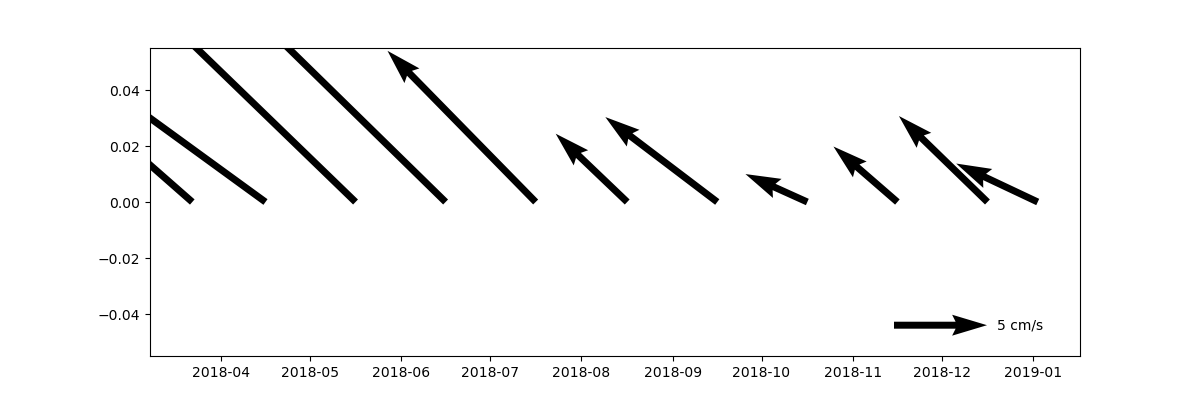

In [262]:
fig = plt.figure(figsize=(12,4))
ds = DITN_2018_vel_top_raw
q = plt.quiver(
    ds.time.resample(time='M').mean().values,np.zeros(len(ds.time.resample(time='M').mean())),
    ds.u.resample(time='M').mean(),
    ds.v.resample(time='M').mean(),
    scale=50, units='width'
)
plt.quiverkey(q, X=0.90, Y=0.1, U=5, label='5 cm/s', labelpos='E')

In [254]:
DITN_2017_vel_bot

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 37484)
Coordinates:
  * time     (time) datetime64[ns] 300kB 2017-02-09T01:15:00 ... 2018-03-06T1...
    z        int64 8B 694
    lat      float64 8B -75.36
    lon      float64 8B 164.7
Data variables: (12/14)
    dirt     (time) float64 300kB ...
    spe      (time) float64 300kB ...
    T        (time) float64 300kB ...
    P        (time) float64 300kB ...
    hdgt     (time) float64 300kB ...
    pitch    (time) float64 300kB ...
    ...       ...
    v        (time) float64 300kB 2.574 1.985 -0.2322 ... -12.65 -15.01 -12.06
    w        (time) float64 300kB ...
    volt     (time) float64 300kB ...
    amp1     (time) float64 300kB ...
    amp2     (time) float64 300kB ...
    amp3     (time) float64 300kB ...
Attributes:
    description:  Mooring DITN 1702 AQD

### Time series of TNBD and DITD temp / sal

In [308]:
TNBD_ctd_bot

<xarray.Dataset> Size: 9MB
Dimensions:             (time: 143040)
Coordinates:
  * time                (time) datetime64[ns] 1MB 2018-03-13T00:01:43 ... 201...
    index               (time) int64 1MB ...
    z                   int64 8B 1093
    lat                 float64 8B ...
    lon                 float64 8B ...
Data variables:
    temp                (time) float64 1MB ...
    pressure            (time) int64 1MB ...
    absolute_salinity   (time) float64 1MB ...
    conservative_temp   (time) float64 1MB ...
    density             (time) float64 1MB ...
    practical_salinity  (time) float64 1MB ...

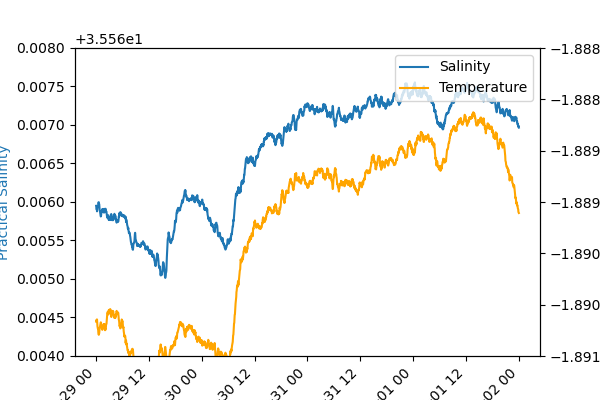

In [325]:
fig, ax = plt.subplots(figsize=(6,4))
ds = TNBD_ctd_bot.rolling(time=10).mean().sel(time=slice('2018-03-29','2018-04-01'))
ax.plot(ds.time,ds.practical_salinity,color='tab:blue',label='Salinity')
ax.set_ylabel('Practical Salinity',color='tab:blue')
ax.set_ylim(35.564,35.568)

ax1 = ax.twinx()
ax1.plot(ds.time,ds.temp,color='orange',label='Temperature')
ax1.set_ylabel('Potential Temperature [°C]',color='orange')
ax1.set_ylim(-1.891,-1.888)
# x ticks on angle 
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# legend
lines, labels = ax.get_legend_handles_labels()
lines1, labels1 = ax1.get_legend_handles_labels()
ax.legend(lines + lines1, labels + labels1, loc='upper right')
